## Intensity Leveling Tutorial 


#### Using this notebook

This notebook walks users through the intensity leveling prodedure used in FalseColor Python. The main use of intensity leveling is outlined in the color_script.py located in the scripts folder, which is currently designed for hdf5 datasets. This intensity leveling method is based on using downsampled data to correct fluorescent images which have uneven staining.

Note: These proedures are not implemented in the CPU falseColor method, yet and are intended for the rapidFalseColor method as outlined below.



In [ ]:
import falsecolor.coloring as fc
import numpy as np
import os
from falsecolor.process import ViewImage
import h5py as h5
from skimage.measure import block_reduce

In [2]:
#Read data from Examples directory

datapath = './h5_sample_data/lung/lung_data.h5'

with h5.File(datapath, 'r') as f:
    nuclei = f['t00000/s00/0/cells'][:]
    cyto = f['t00000/s01/0/cells'][:]
f.close()
print(nuclei.shape)

(1024, 17, 1024)


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1653f346400>)

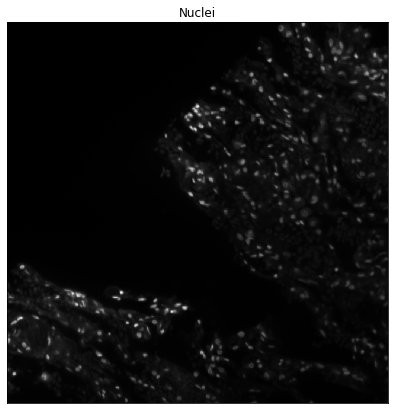

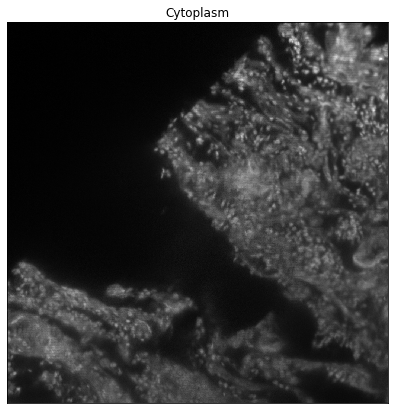

In [3]:
#View raw data. In the nuclear image, nuclei on the right are dimmer than those on the left
ViewImage(nuclei[:,0], cmap = 'gray', figsize = (7,7), title = 'Nuclei')
ViewImage(cyto[:,0], cmap = 'gray', figsize = (7,7), title = 'Cytoplasm')

##### To compensate for that we will level the intensities of each image using versions of the raw data
Here we will generate downsampled data using block reduction

In [4]:


#The data is downsampled by a factor of 8 on each axis using an averaging method
nuc_ds = block_reduce(nuclei, (8,8,8), np.mean)
cyto_ds = block_reduce(cyto, (8,8,8), np.mean)
print(nuc_ds.shape)

(128, 3, 128)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1653f83efd0>)

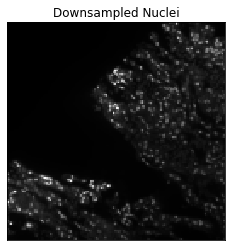

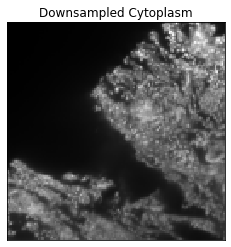

In [5]:
ViewImage(nuc_ds[:,0], cmap = 'gray', title = 'Downsampled Nuclei')
ViewImage(cyto_ds[:,0], cmap = 'gray', title = 'Downsampled Cytoplasm')

#### Generating 3D intensity leveling maps

To generate a 3D intensity leveling map we use fc.getFlatField(). This method assumes 3D image data is the first argument. The intensity leveling map is generated by further partitioning the downsampled data into equal sized cubes and calculating the median value of each data cube. Data cube size is controlled using the tileSize parameter. The smaller the data cube size, the higher resolution the final 3D map will be. Lower resolution maps will level the intensity over larger areas.


This method also returns the calculated background level (assumed to be 20% of the value above the detector noise floor). This is controlled by the bg_threshold parameter (background threshold, a pixel value under which everything is considered noise).

In [6]:
#Calculate flatfield from background subtracted data
nuclear_map = fc.getIntensityMap(nuc_ds, tileSize = 128,  blockSize = 8, bgThreshold = 50)
cytoplasm_map = fc.getIntensityMap(cyto_ds, tileSize = 128, blockSize=8, bgThreshold = 50)

print(nuclear_map.shape)

(8, 1, 8)


In [7]:
#finally the intensity leveling maps for each channel are interpolated to the size of the full res data
#an additional argument k is needed which refers to the index of the full res data in it's orignal format.
#The size of the final interpolation is controlled by the tileSize parameter, which should match that used previously
C_nuc = fc.interpolateDS(nuclear_map, 0, tileSize = 128)
C_cyto = fc.interpolateDS(cytoplasm_map, 0 , tileSize = 128, beta = 3.7)

In [8]:
#The leveling map for our image should now be the same size as the full res data
print(C_nuc.shape, nuclei[:,0].shape)

(1024, 1024) (1024, 1024)


In [9]:
#The intensity leveling process in rapidFalseColor() assumes data has already undergone background subtraction

nuclear_background = fc.getBackgroundLevels(nuc_ds)[1]
cytoplasm_background = fc.getBackgroundLevels(cyto_ds)[1]

nuc_nobg = np.clip(nuclei[:,0] - 0.5*nuclear_background, 0, 2**16)
cyto_nobg = np.clip(cyto[:,0] - cytoplasm_background, 0, 2**16)

In [10]:
#Get RGB color settings
settings_dict = fc.getColorSettings()
nuclei_RGBsettings = settings_dict['nuclei']
cyto_RGBsettings = settings_dict['cyto']

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1653f93b700>)

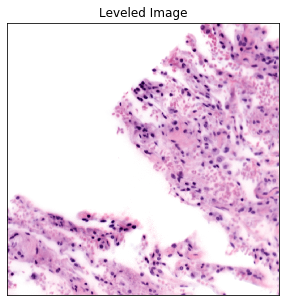

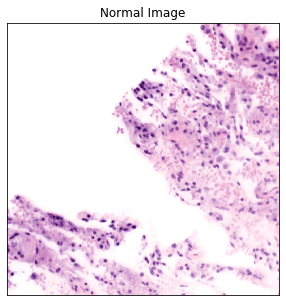

In [11]:
level_virtualHE = fc.rapidFalseColor(nuc_nobg, cyto_nobg, nuclei_RGBsettings, cyto_RGBsettings,
                                            run_FlatField_nuc = True, run_FlatField_cyto = True,
                                            nuc_normfactor = C_nuc,
                                            cyto_normfactor = C_cyto)

#the non intensity leveling false coloring has a background subtraction included in the process
virtualHE = fc.rapidFalseColor(nuclei[:,0], cyto[:,0], nuclei_RGBsettings, cyto_RGBsettings)

ViewImage(level_virtualHE, title = 'Leveled Image', figsize = (5,5))
ViewImage(virtualHE, title = 'Normal Image', figsize = (5,5))